# **Binary Signal Recovery Using the Metropolis-Hastings Algorithm**

## Introduction

This project aims to recover an unknown binary signal using the Metropolis-Hastings algorithm, a stochastic sampling technique. In the context of signal processing and statistical inference, the goal is to estimate a binary parameter vector $\theta$ from noisy observations $y$. Using the Metropolis-Hastings algorithm, the project explores the space of solutions to minimise an objective function $\mathcal{H}(X, y, \theta)$, studying how the mean square error $(\operatorname{MSE})$ varies with the number of measurements $m$.

## Problem definition
### Signal model

- $X \in \mathbb{R}^{m \times d}$ a random sensing matrix with i.i.d. entries sampled from $N(0, 1)$;

- $\xi \in \mathbb{R}^{m}$ be a noise vector, independent of $X$, with i.i.d. entries sampled from $N(0, 1)$;

- $\Theta = \{0, 1\}^{d}$ is the signal space let $\theta \in \Theta$ (signal) be chosen uniformly at random and be independent of the pair $(X, \xi)$.

The measurement vector $y \in \mathbb{R}^{m}$ is generated as $$y = X\theta + \xi$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [ ]:
def generate_data(m, d):
    X = np.random.normal(0, 1, (m, d))
    xi = np.random.normal(0, 1, m)
    theta = np.random.choice([0, 1], d)
    y = X @ theta + xi
    return X, y, theta

## Maximum likelihood estimate

Maximum Likelihood Estimation (MLE) is a statistical method used to estimate the parameters of a probabilistic model. The objective of MLE is to find parameter values that maximise the probability of observing the sampled data, thus providing the most plausible estimates for the unknown parameters of the model.

The maximum likelihood estimate of $\theta$ is given by the value $\hat{\theta} \in \Theta$ that maximizes the likelihood function

$$\mathcal{L}(X,y; \theta) = \frac{\exp\left\{-\frac{1}{2} \left(y - X\theta\right)^T\left(y - X\theta\right)\right\}}{(2 \pi)^{m/2}}$$
given the observation $(X, y)$.

We can equivalently cast the question in the form of a minimization problem, the maximum likelihood estimate of $\theta$ is given by the value $\hat{\theta} \in \Theta$ that minimizes the function

$$\mathcal{H}(X, y; \theta) = \left(y - X\theta\right)^T\left(y - X\theta\right)$$

## Metropolis Hastings Algorithm

The Metropolis-Hastings algorithm is a Monte Carlo Markov Chain (MCMC) technique used to generate samples from complex probability distributions. It explores the space of solutions by proposing new positions and accepting them with a certain probability, making it possible to approximate the distribution of interest even when it is not possible to sample it directly.

We construct the Metropolis-Hastings (discrete-time) Markov chain on the state space $\theta$, with stationary distribution

$$\pi_{\beta}(\theta) = \frac{e^{-\beta \mathcal{H}(X,y; \theta)}}{Z_\beta}, \quad \text{with} \quad Z_\beta = \sum_{\theta \in \Theta}e^{-\beta \mathcal{H}(X,y; \theta)}$$

**Stationary Distribution:** The stationary distribution $\pi_\beta$ is the distribution to which the Markov chain converges after many iterations. This distribution represents the probability of finding the chain in a specific state $\theta$ in the long run.

### Algorithm
**1. Initialization**

Set $\theta_0 = \bar{\theta}$

**2. Iteration**

For t = 1, 2, ..., d:
  
  1. pick $i$ uniformly at random in $\{1,2,...,d\}$;

  2. let the proposed state be $\theta^{*} \in \theta$, with entries
  $$\theta^{*}(j) = \begin{cases}\theta_{t-1}(j) & \text{if } j\neq i\\
  1 - \theta_{t-1}(j) & \text{if } j = i\end{cases}$$

  3. Set
  $$\theta_{t}(j) = \begin{cases}\theta^{*}(j) & \text{with probability } \min\left\{1, \frac{e^{- \beta \mathcal{H}(X, y; \theta^*)}}{e^{- \beta \mathcal{H}(X, y; \theta_{t-1})}}\right\}\\
  \theta_{t-1}(j) & \text{with probability } 1 - \min\left\{1, \frac{e^{- \beta \mathcal{H}(X, y; \theta^*)}}{e^{- \beta \mathcal{H}(X, y; \theta_{t-1})}}\right\}\end{cases}$$

In [ ]:
def Metropolis_Hastings(X, y, theta, beta, N):
    d = theta.shape[0]
    i = np.random.randint(0, d, N)
    p = np.random.rand(N, 1)
    H_init = np.dot((y - X @ theta), (y - X @ theta))
    for t in range(N):
        theta_star = theta.copy()
        theta_star[i[t]] = 1 - theta_star[i[t]]
        H_star = np.dot((y - X @ theta_star), (y - X @ theta_star))
        acceptance_ratio = min(1, np.exp(- beta * (H_star - H_init)))
        if p[t] < acceptance_ratio:
            theta = theta_star
            H_init = H_star
    return theta

To check the quality of our estimate, we analyze the mean squared error

$$\epsilon = \mathbb{E}\left((\hat{\theta} - \theta) ^T(\hat{\theta} - \theta)\right)$$

In [ ]:
def MSE(theta_true, theta_pred):
    residuals = theta_pred - theta_true
    return np.dot(residuals, residuals)

### Beta evaluation

When choosing the parameter $\beta$ for the Metropolis-Hastings algorithm, the goal is to achieve good exploration of the solution space and fast convergence to the stationarity distribution. The parameter $\beta$ influences the acceptance of state proposals and thus the overall effectiveness of the algorithm.

### Role of $\beta$ in the Metropolis-Hastings algorithm

1. **$\beta$ and the Stationary Distribution**:
   $\beta$ appears in the definition of the stationary distribution $\pi_{\beta}(\theta)$:

   $$
   \pi_{\beta}(\theta) = \frac{e^{-\beta\mathcal{H}(X, y; \theta)}}{Z_{\beta}}
   $$

   where $Z_{\beta}$ is the partition function that normalises the distribution. As $\beta$ increases, the distribution becomes more concentrated around the minima of the energy function $\mathcal{H}(X, y; \theta)$.

2. **Acceptance of Proposals**:
   The probability of accepting a proposed state $\theta^*$ is given by:

   $$
   \min \left(1, \frac{e^{-\beta H(X, y; \theta^*)}}{e^{-\beta H(X, y; \theta_{t-1})}} \right)
   $$

   If $\beta$ is too small, the difference in acceptance probabilities between states will be small, and the algorithm will accept almost all proposals, leading to poor exploration of low-energy regions. If $\beta$ is too large, the algorithm will become too selective, accepting only a few proposals and becoming trapped in local minima.

In [ ]:
d = 10
m = 15
ms = range(1, m + 1)
beta_values = [0.1, 0.5, 1, 2, 5]
N = 100
M = 1000

In [ ]:
MSE_result = {}

for beta in beta_values:
    MSE_values = []
    for s in ms:
        errors = []
        for _ in range(M):
            X, y, theta_true = generate_data(s, d)
            theta_init = np.random.randint(0, 2, d)
            theta_est = Metropolis_Hastings(X, y, theta_init, beta, N)
            error = MSE(theta_true, theta_est)
            errors.append(error)
        mse = np.mean(errors)
        MSE_values.append(mse)
    MSE_result[beta] = MSE_values

table = PrettyTable()

field_names = ["beta"] + [f"m = {s}" for s in ms]
table.field_names = field_names

for beta, mse_values in MSE_result.items():
    row = [beta] + mse_values
    table.add_row(row)

print(table)

+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+
| beta | m = 1 | m = 2 | m = 3 | m = 4 | m = 5 | m = 6 | m = 7 | m = 8 | m = 9 | m = 10 | m = 11 | m = 12 | m = 13 | m = 14 | m = 15 |
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+
| 0.1  | 4.832 | 4.654 | 4.533 | 4.329 | 4.179 | 3.994 | 3.933 | 3.729 | 3.533 | 3.447  | 3.249  | 3.225  | 2.959  | 2.859  | 2.773  |
| 0.5  | 4.669 | 4.274 | 4.019 | 3.675 | 3.289 | 2.894 | 2.725 | 2.468 |  2.15 | 1.916  | 1.716  | 1.571  | 1.363  | 1.135  | 1.019  |
|  1   | 4.658 |  4.13 | 3.784 | 3.419 | 3.172 | 2.656 | 2.488 | 2.306 |  2.04 | 1.894  | 1.639  | 1.347  | 1.282  | 1.044  | 0.986  |
|  2   | 4.604 | 4.144 |  3.76 | 3.395 | 3.128 | 2.889 | 2.409 | 2.186 | 2.019 | 1.811  | 1.679  | 1.462  | 1.309  | 1.122  | 1.007  |
|  5   |  4.57 | 4.203 | 3.791 | 3.336 | 3.131 | 2.861 

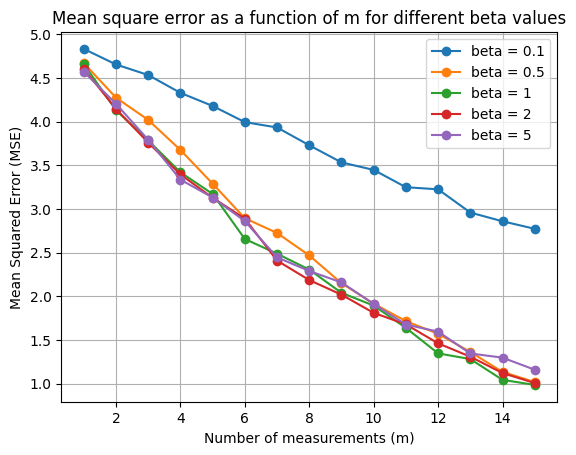

In [ ]:
for beta in beta_values:
    plt.plot(ms, MSE_result[beta], marker = 'o', label = f'beta = {beta}')
plt.xlabel('Number of measurements (m)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean square error as a function of m for different beta values')
plt.legend()
plt.grid(True)
plt.show()

$\beta = 1$ turns out to be the best choice for solving the problem

The mean squared error $\epsilon$ can be estimated by exploiting the law of large numbers. Let $M$ denote the number of independent realizations of $(\theta, X, y)$. Moreover, let $\hat{\theta}(j)$ be the maximum likelihood estimate of the $j$-th signal $\theta(j)$, obtained by the $j$-th run of the Metropolis-Hastings algorithm, given $(X(j),y(j))$. If $M$ is sufficiently large (use $M$ of order $10^4$), then we have the approximation

$$ \epsilon \approx \frac{1}{M} \sum_{j = 1}^{M} \left((\hat{\theta}^{(j)} - \theta^{(j)}) ^T(\hat{\theta}^{(j)} - \theta^{(j)})\right)$$

In [ ]:
d = 10
m = 15
ms = range(1, m + 1)
beta = 1.0
N = 1000
M = 10000

In [ ]:
MSE_values = []

table = PrettyTable()
table.field_names = ["", "MSE"]

for s in ms:
    errors = []
    for _ in range(M):
        X, y, theta_true = generate_data(s, d)
        theta_init = np.random.randint(0, 2, d)
        theta_est = Metropolis_Hastings(X, y, theta_init, beta, N)
        error = MSE(theta_true, theta_est)
        errors.append(error)
    mse = np.mean(errors)
    MSE_values.append(mse)
    table.add_row([f'm = {s}', mse])

print(table)

+--------+--------+
|        |  MSE   |
+--------+--------+
| m = 1  | 4.5864 |
| m = 2  | 4.2057 |
| m = 3  | 3.7951 |
| m = 4  | 3.4052 |
| m = 5  | 3.037  |
| m = 6  | 2.6915 |
| m = 7  | 2.3787 |
| m = 8  | 2.0472 |
| m = 9  | 1.8169 |
| m = 10 | 1.5684 |
| m = 11 | 1.3894 |
| m = 12 | 1.2012 |
| m = 13 | 1.057  |
| m = 14 | 0.9111 |
| m = 15 | 0.8078 |
+--------+--------+


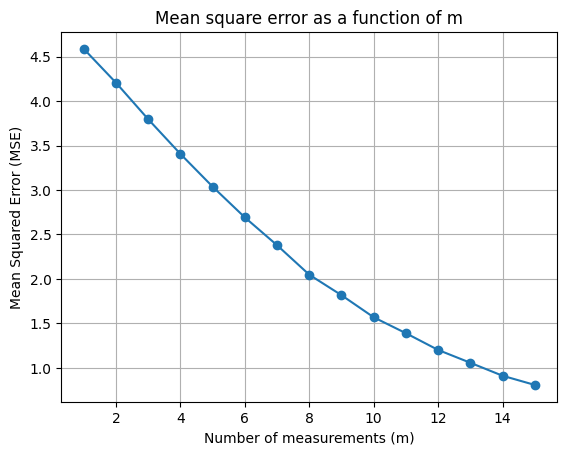

In [ ]:
plt.plot(ms, MSE_values, marker = 'o')
plt.xlabel('Number of measurements (m)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean square error as a function of m')
plt.grid(True)
plt.show()

In [ ]:
#Determine the minimum value of m for which the MSE is sufficiently low

threshold_MSE = 1.0  #Arbitrary threshold to consider the estimate reliable
reliable_m_indices = [i for i, MSE in enumerate(MSE_values) if MSE < threshold_MSE]
if reliable_m_indices:
    min_m = ms[reliable_m_indices[0]]
    print(f"Minimum value of m/d to reliably recover theta: {min_m/d:.2f}")
else:
    print("No value of m was found for which the MSE is below the threshold.")

Minimum value of m/d to reliably recover theta: 1.40
